In [6]:
from datetime import datetime
import json
import os
import os.path as path
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint

from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
from gensim.models.phrases import Phraser, Phrases, ENGLISH_CONNECTOR_WORDS

In [2]:
# directories
output_dir = "../output"
data_dir = "../data"
selfparsed_dir = path.join(data_dir, "selfparsed")

# misc
GROUPS = ['other', 'sustainability']
pd.set_option('display.max_colwidth', None)

## Functions

In [31]:
# various utility functions
def get_timestamp():
    return datetime.now().strftime("%Y-%m-%d-%H%M")

def read(filepath, max_lines=None):
    # check arguments
    assert path.exists(filepath)
    if max_lines:
        assert isinstance(max_lines, int) and max_lines > 0

    print(f"Reading {filepath}")

    # read multi-line json file
    if filepath.endswith(".jsonl"):
        data = []
        with open(filepath, 'r') as f:
            for i, line in enumerate(f):
                if i == max_lines:
                    break
                data.append(json.loads(line))
    
    # read single-line json file
    elif filepath.endswith(".json"):
        with open(filepath, 'r') as f:
            data = json.load(f)

    # read possibly multi-line text file
    elif filepath.endswith(".txt"):
        with open(filepath, 'r') as f:
            data = f.readlines()[:max_lines]

    else:
        print(f"The extension for {filepath} is not yet handled")
        data = []
    return data

# format LDA topics detected for readability
def get_formatted_topics(lda_model):
    formatted_topics = []
    for _, topic in lda_model.show_topics():
        entries = []
        for entry in topic.split(" + "):
            score, word = entry.split("*")
            score = float(score)
            word = word.strip().replace("\"", '')
            entries.append((score, word))
        formatted_topics.append(entries)
    return formatted_topics

In [32]:
def process(texts, no_below=10, no_above=0.4):
    print("\nBuilding phrased texts, id2word, and word_ids")
    # returns phrased texts, id2word, and word_ids for input texts

    # create corpus of bigrams from input texts
    bigram_phraser = Phrases(texts, min_count=10)
    texts = [bigram_phraser[text] for text in texts]

    # create id2word and filter extremes
    id2word = Dictionary(texts)
    print(f"Size of original id2word: {len(id2word)}")

    id2word.filter_extremes(no_below=no_below, no_above=no_above)
    print(f"Size of filtered id2word: {len(id2word)}")

    # build BoW embeddings
    word_ids = [id2word.doc2bow(text) for text in texts]

    return texts, id2word, word_ids

In [33]:
# validation function for determining best num_topics
def validate(
    texts, id2word, word_ids, num_topics_range, 
    coherence='c_v', workers=1):
    # return dictionary of coherence score at each num_topics value

    print(f"\nValidating LDA model for coherence over {num_topics_range}")

    validation_results = []
    for num_topics in tqdm(num_topics_range):
        # initialise LDA model
        if workers == 1:
            lda_model = LdaModel(
                corpus=word_ids, 
                id2word=id2word,
                num_topics=num_topics,
                alpha='auto',
                eta='auto',
                random_state=1,
            )
        else:
            lda_model = LdaMulticore(
                corpus=word_ids, 
                id2word=id2word,
                num_topics=num_topics,
                workers=workers,
                random_state=1,
            )
        
        # initialise coherence evaluation model
        coherence_model = CoherenceModel(
            model=lda_model,
            texts=texts,
            dictionary=id2word,
            coherence=coherence,
        )

        # compute coherence and detected topics
        result = {
            'num_topics': num_topics, 
            'coherence': coherence_model.get_coherence(), 
            'topics': get_formatted_topics(lda_model)
        }
        validation_results.append(result)

    return validation_results

## Run validation

In [34]:
# load data
data = []
for group in GROUPS:
    filepath = path.join(
        selfparsed_dir, f"preprocessed-english-{group}-noaliases.jsonl")
    group_data = read(filepath)
    data.extend(group_data)

# get texts as list of paragraphs across all documents
print(f"Number of texts: {len(data)}")

Reading ../data/selfparsed/preprocessed-english-other-noaliases.jsonl
Reading ../data/selfparsed/preprocessed-english-sustainability-noaliases.jsonl
Number of texts: 153


In [35]:
# TODO: find reasonable and optimal requirements on paragraph lengths
# for now, set min length of 5 tokens and max length of 400 tokens
paragraphs = []
for text in [x['preprocessed'] for x in data]:
    for para in text:
        if len(para) > 10:
            paragraphs.append(para)
            
print(f"Number of paragraphs: {len(paragraphs)}")

Number of paragraphs: 42527


In [36]:
# choose num_topics based on coherence
# change flag to 'True' to run
if True:

    # process paragraphs as documents
    phrased_paragraphs, id2word, word_ids = process(
        texts=paragraphs,
        no_below=5,
        no_above=0.5,
    )

    # run validation
    validation_results = validate(
        texts=phrased_paragraphs, 
        id2word=id2word, 
        word_ids=word_ids, 
        num_topics_range=range(1, 3, 1),
        coherence='c_v'
    )
        
    # prepare save directory and path
    save_dir = path.join(output_dir, get_timestamp())
    os.mkdir(save_dir)
    
    # export validation results
    outpath = path.join(save_dir, "validation-combined-noaliases.jsonl")
    with open(outpath, 'w') as f_out:
        for result in validation_results:
            print(json.dumps(result), file=f_out)
    print(f"Validation results are saved at {outpath}")



Building phrased texts, id2word, and word_ids
Size of original id2word: 43926
Size of filtered id2word: 17421

Validating LDA model for coherence over range(1, 3)


100%|██████████| 2/2 [00:24<00:00, 12.37s/it]

Validation results are saved at ../output/2021-12-17-1857/validation-combined-noaliases.jsonl


### Inspect validation results

In [42]:
# load validation results
# replace with appropriate timestamp
filepath = path.join(
    output_dir, "2021-12-17-1635", "validation-combined-noaliases.jsonl")

validation_results = read(filepath)

Reading ../output/2021-12-17-1635/validation-combined-noaliases.jsonl


In [55]:
# output reader friendly validation_results
outpath = path.join(
    path.dirname(filepath), "formatted-" + path.basename(filepath))
with open(outpath, 'w') as f_out:
    for x in validation_results:
        print(
            f"num_topics = {x['num_topics']}, coherence = {x['coherence']:.5}",
            file=f_out)

        for topic in x['topics']:
            words = [entry[1] for entry in topic]
            print("- " + " ".join(words), file=f_out)
        print("", file=f_out)

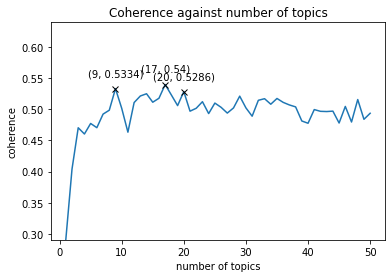

In [43]:
# plot coherence vs num_topics
num_topics = [_['num_topics'] for _ in validation_results]
coherences = np.array([_['coherence'] for _ in validation_results])

plt.ylim(min(coherences), max(coherences) + 0.1)
plt.plot(num_topics, coherences)

# annotate top three coherence scores
best_indices = np.argsort(coherences)[-3:]
for i in best_indices:
    bestk = num_topics[i]
    score = coherences[i]
    plt.plot(bestk, score, marker='x', color='black')
    plt.text(
        x=bestk, y=score+0.02, s=f"({bestk}, {score:.4})", 
        horizontalalignment='center')

plt.title("Coherence against number of topics")
plt.ylabel("coherence")
plt.xlabel("number of topics")
plt.show()